In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 400)

# ======================
# DATA CLEANING
# ======================

# FISH DETAILS

In [2]:
dtypes = {
    'YEAR': 'Int32', 
    'MM': 'Int32', 
    'DD': 'Int32', 
    'WEEK': 'Int32', 
    'SITE': 'object', 
    'PERIOD': 'object', 
    'CONDITION': 'object', 
    'FISH_NO': 'Int32', 
    'FL_WET.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_FROZEN.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_STD.x': 'float64',
    'WEIGHT': 'float64',
    'SPECIES': 'object', 
    'SEX': 'object', 
    'MATURITY.x': 'object',  # two entries that at 3?, (also 1 that is 44), convert to numeric, coerce errors
    'GONAD_WEIGHT': 'object',  # some '.' / 'NA', convert to numeric, coerce error to make 'NA' actually null
    'Ager.1': 'object',
    'AGE.1': 'object',  # convert to numeric and separate text comments
    'FSP.1': 'object',  # convert to numeric and separate text comments
    'Comments.1': 'object', 
    'Ager.2': 'object',  
    'AGE.2': 'object',  # convert to numeric and separate text comments
    'FSP.2': 'object',  # convert to numeric and separate text comments
    'Comments.2': 'object', 
    'Ager.3': 'object', 
    'AGE.3': 'object',  # convert to numeric and separate text comments
    'FSP.3': 'object',  # convert to numeric and separate text comments
    'Comments.3': 'object', 
    'Envelop Comments': 'object'
} 

df_FD = pd.read_excel('provided data\\Gaspereau Ages_Combined.xlsx', dtype=dtypes)

# create backup of notes (including all numeric data for simplicity)
df_FD['AGE_notes_1'] = df_FD['AGE.1']
df_FD['FSP_notes_1'] = df_FD['FSP.1']
df_FD['AGE_notes_2'] = df_FD['AGE.2']
df_FD['FSP_notes_2'] = df_FD['FSP.2']
df_FD['AGE_notes_3'] = df_FD['AGE.3']
df_FD['FSP_notes_3'] = df_FD['FSP.3']

# convert to numeric and coerce errors
# for FL_WET.x, one measurement is a float (258.8), all else are int, need to round to convert to int
df_FD['FL_WET.x'] = np.round(pd.to_numeric(df_FD['FL_WET.x'], errors='coerce')).astype('Int32')
df_FD['FL_FROZEN.x'] = pd.to_numeric(df_FD['FL_FROZEN.x'], errors='coerce').astype('Int32')
df_FD['MATURITY.x'] = pd.to_numeric(df_FD['MATURITY.x'], errors='coerce').astype('Int32')
df_FD['GONAD_WEIGHT'] = pd.to_numeric(df_FD['GONAD_WEIGHT'], errors='coerce')  # float
df_FD['AGE.1'] = pd.to_numeric(df_FD['AGE.1'], errors='coerce').astype('Int32')
df_FD['FSP.1'] = pd.to_numeric(df_FD['FSP.1'], errors='coerce').astype('Int32')
df_FD['AGE.2'] = pd.to_numeric(df_FD['AGE.2'], errors='coerce').astype('Int32')
df_FD['FSP.2'] = pd.to_numeric(df_FD['FSP.2'], errors='coerce').astype('Int32')
df_FD['AGE.3'] = pd.to_numeric(df_FD['AGE.3'], errors='coerce').astype('Int32')
df_FD['FSP.3'] = pd.to_numeric(df_FD['FSP.3'], errors='coerce').astype('Int32')

# rename keys with '.' for ease of use within pandas
rename_FD = {
    'FL_WET.x': 'FL_WET', 
    'FL_FROZEN.x': 'FL_FROZEN',
    'FL_STD.x': 'FL_STD', 
    'MATURITY.x': 'MATURITY',
    'Ager.1': 'Ager_1',
    'AGE.1': 'AGE_1',
    'FSP.1': 'FSP_1',
    'Comments.1': 'Comments_1',
    'Ager.2': 'Ager_2',
    'AGE.2': 'AGE_2',
    'FSP.2': 'FSP_2',
    'Comments.2': 'Comments_2',
    'Ager.3': 'Ager_3',
    'AGE.3': 'AGE_3',
    'FSP.3': 'FSP_3',
    'Comments.3': 'Comments_3'
}
df_FD = df_FD.drop('Unnamed: 0', axis=1).rename(columns=rename_FD)

# create a DATETIME column
df_FD['DATETIME'] = pd.to_datetime(df_FD['YEAR'].astype(str) + '-' + df_FD['MM'].astype(str) + '-' + df_FD['DD'].astype(str))

# move the DATETIME column to the front of the dataframe
df_FD = df_FD[['DATETIME'] + [col for col in df_FD.columns if col != 'DATETIME']]

### SITE: Clean, Backup, Remap, and Take 1st Entry
* convert to int for processing (will be undone during import)

In [3]:
# how many named vs na sites
(
    sum(~df_FD.SITE.astype(str).str.isnumeric()) - sum(df_FD.SITE.isin(['1A', '1B'])) - df_FD[df_FD.SITE.isnull()].shape[0], 
    df_FD[df_FD.SITE.isnull()].shape[0], 
    sum(~df_FD.SITE.astype(str).str.isnumeric()) - sum(df_FD.SITE.isin(['1A', '1B']))
)
# named, null, total ambiguous

(1804, 118, 1922)

In [4]:
# add a flag for sites if there is ambiguous data (ie, names, multiple sites, alternate nomenclature)
df_FD.loc[(
    df_FD.SITE.isnull() | ~(df_FD.SITE.astype(str).str.isnumeric() | df_FD.SITE.isin(['1A', '1B']))
), 'FLAG_SITE'] = True

# how many Site flags are there?
df_FD[df_FD.FLAG_SITE == True].shape[0]

1922

In [5]:
# clean the site column before investigating in detail

# backup exact site entries as site notes
df_FD['SITE_notes'] = df_FD['SITE'].astype('str')

# Expand and Clean Site Column
df_FD[['SITE1', 'SITE2', 'SITE3']] = df_FD.SITE.astype('str').str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

In [6]:
# remap sites to numeric, overwrite SITE (after backing up notes), convert to integer

# these indices/numbers are important/exact, but will be undone on import to dm_apps
# these are consistent with older analysis, other tables, and import script into dm_apps
remap_sites = {
    '1A': 90,
    '1B': 91,
    '47or62': 47,
    'EricMcFarlane': 92,
    'E.MACFARLANE': 92,
    'EricMacFarlane': 92,
    'EricMac': 92,
    'JimmyMacFarlane': 93,
    'JMcFarlane': 93,
    'JohnAlbertCoady': 94,
    'JACoady': 94,
    '11K3(435': 95
}

df_FD['SITE'] = df_FD.replace({'SITE1': remap_sites}).SITE1
df_FD['SITE'] = pd.to_numeric(df_FD['SITE'], errors='coerce').astype('Int32')

# Naming Issues

In [7]:
# extra space
df_FD.loc[df_FD.PERIOD == 'PM ', 'PERIOD'] = 'PM'

# formatting
df_FD.loc[df_FD.CONDITION == 'FROZEN', 'CONDITION'] = 'Frozen'
df_FD.loc[df_FD.CONDITION == 'FRESH', 'CONDITION'] = 'Fresh'

### PERIOD: convert 'AD' to 'AM' - CONFIRM
* (118 entries)
* Other CSV also include AD periods for entered data

In [8]:
# Set a flag for AD period data
df_FD.loc[df_FD.PERIOD == 'AD', 'FLAG_AM_PM_PERIOD'] = True

# how many flagged data?
df_FD[df_FD.FLAG_AM_PM_PERIOD == True].shape[0]

118

In [9]:
# # leave for now

# # convert AD to AM
# confirm_AD_to_AM = False

# if confirm_AD_to_AM:
#     df_FD.loc[df_FD.PERIOD == 'AD', 'PERIOD'] = 'AM'

### SEX: leave or null 'B' / 'A?' - CONFIRM
* confirm B is not 'both' (if so, could change label to 'H' for hermaphrodite)

In [10]:
# TODO: send this

sum(df_FD.SEX == 'B'), sum(df_FD.SEX == 'A?')

(1, 1)

In [11]:
df_FD.loc[(df_FD.SEX == 'B') | (df_FD.SEX == 'A?'), 'FLAG_SEX'] = True

# how many flags
df_FD[df_FD.FLAG_SEX == True].shape[0]

2

In [12]:
# # LEAVE FOR NOW

# confirm_SEX_B_null = False

# if confirm_SEX_B_null:
#     df_FD.loc[df_FD.SEX == 'B', 'SEX'] = np.nan
        
# confirm_SEX_B_actually_H = False

# if confirm_SEX_B_actually_H:
#     df_FD.loc[df_FD.SEX == 'B', 'SEX'] = 'H'
    
# confirm_SEX_Aq_null = False

# if confirm_SEX_Aq_null:
#     df_FD.loc[df_FD.SEX == 'A?', 'SEX'] = np.nan

# Outliers

### MATURITY: set 0 to null - CONFIRM
* NOTE: could also set this to 9 (unknown), or 99 (Abnormal)

### MATURITY: leave or null '44' - CONFIRM
* could also be typo for 4
* NOTE: could also set this to 9 (unknown), or 99 (Abnormal)

In [13]:
sum(df_FD[df_FD.MATURITY.notna()].MATURITY == 0), sum(df_FD[df_FD.MATURITY.notna()].MATURITY == 44)

(2, 1)

In [14]:
# Flag Maturity Outliers / Typos

df_FD.loc[(df_FD.MATURITY == 0) | (df_FD.MATURITY == 44), 'FLAG_MATURITY'] = True

# how many flags?
df_FD[df_FD.FLAG_MATURITY == True].shape[0]

3

In [15]:
# # LEAVE FOR NOW

# confirm_MATURITY_0_null = False

# if confirm_MATURITY_0_null:
#     df_FD.loc[df_FD.MATURITY == 0, 'MATURITY'] = np.nan

    
# confirm_MATURITY_0_9 = False

# if confirm_MATURITY_0_null:
#     df_FD.loc[df_FD.MATURITY == 0, 'MATURITY'] = 9


# # LEAVE FOR NOW

# confirm_MATURITY_44_null = False

# if confirm_MATURITY_44_null:
#      df_FD.loc[df_FD.MATURITY == 44, 'MATURITY'] = np.nan
        
# confirm_MATURITY_44_actually_4 = False

# if confirm_MATURITY_44_null:
#      df_FD.loc[df_FD.MATURITY == 44, 'MATURITY'] = 4

### FSP_1: leave or null '33' - CONFIRM
* could also be typo for 3

In [16]:
sum(df_FD[df_FD.FSP_1.notna()].FSP_1 == 33)

1

In [17]:
# Flag FSP outliers

df_FD.loc[(df_FD.FSP_1 == 33), 'FLAG_FSP_1'] = True

# how many flags?
df_FD[df_FD.FLAG_FSP_1 == True].shape[0]

1

In [18]:
# # Leave for now

# confirm_FSP_1_33_null = False

# if confirm_FSP_1_33_null:
#      df_FD.loc[df_FD.FSP_1 == 33, 'FSP_1'] = np.nan
        
# confirm_FSP_1_33_actually_4 = False

# if confirm_FSP_1_33_null:
#      df_FD.loc[df_FD.FSP_1 == 33, 'FSP_1'] = 3

### Q: What is happening with the ~2019 data?

##### data input issues?
* there were order of magnitude difference betwwen FL_STD:
  * look to be 10x smaller
* similarly, month 6, there were five strange entries for FL_WET and FL_FROZEN


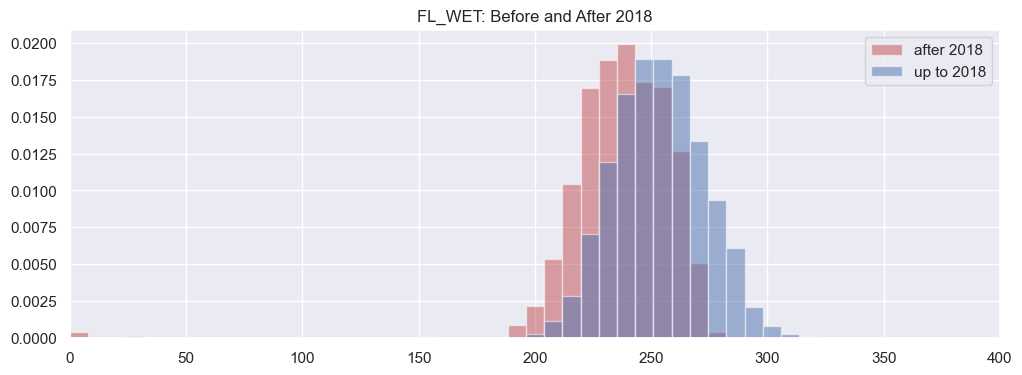

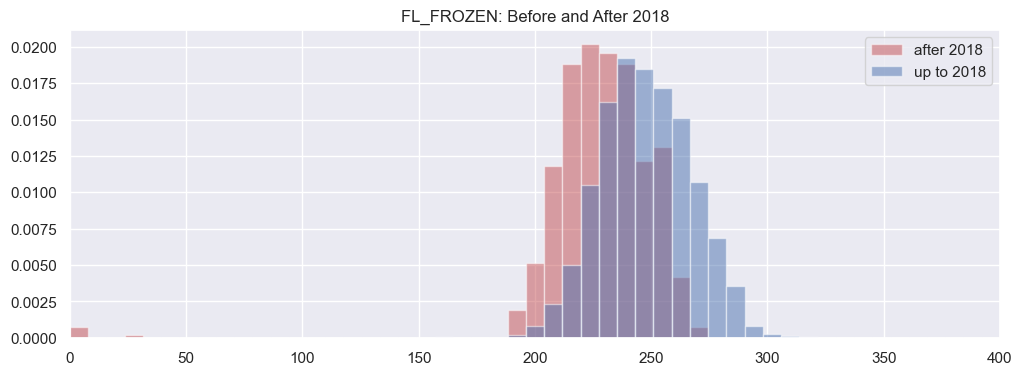

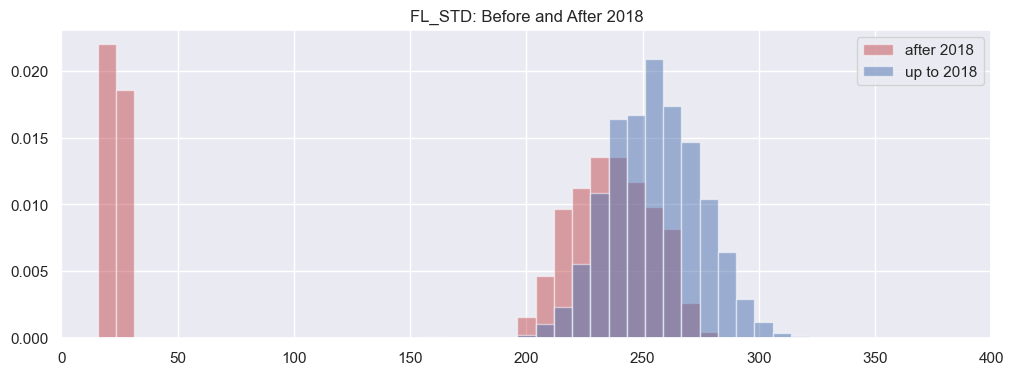

In [19]:
def hist_compare_years(year, feature, bins=50, xmin=0, xmax=400):
    
    plt.figure(figsize=(12,4))
    plt.xlim(xmin, xmax)
    
    bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 
    
    df_FD.loc[df_FD.DATETIME.dt.year > year, feature].hist(alpha=0.5, color=sns.color_palette()[3], density=True, label=f'after {year}', bins=bins_plot)
    df_FD.loc[df_FD.DATETIME.dt.year <= year, feature].hist(alpha=0.5, density=True, label=f'up to {year}', bins=bins_plot)
    
    plt.legend(loc='upper right')
    
    plt.title(feature.upper() + ': Before and After ' + str(year))
    plt.show()
    

# compare years and features
features_to_compare = ['FL_WET', 'FL_FROZEN', 'FL_STD']
years_to_compare = [2018]

for feature in features_to_compare:
    for year in years_to_compare:
        hist_compare_years(year, feature)

### FL_STD: null or scale - CONFIRM

In [20]:
# how many length outliers?

sum(df_FD.FL_STD < 100)

264


outlier min date: 2019-05-31 00:00:00
outlier max date: 2019-06-21 00:00:00


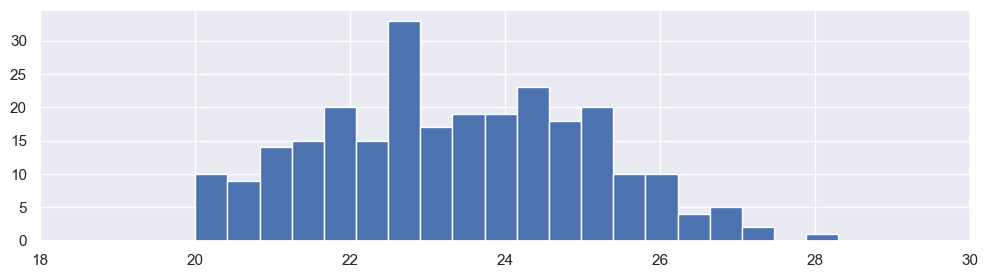

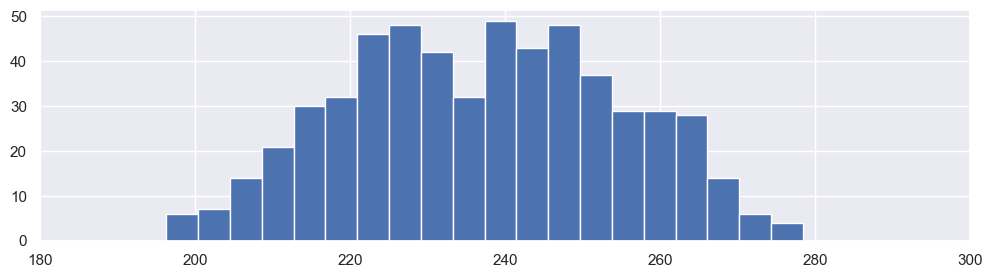

In [21]:
# looks like it's off by a multiple
print()
print('outlier min date:', df_FD[df_FD.FL_STD < 100].DATETIME.min())
print('outlier max date:', df_FD[df_FD.FL_STD < 100].DATETIME.max())

df_FD[df_FD.FL_STD < 100].FL_STD.hist(figsize=(12,3), bins=20)
plt.xlim(18, 30)
plt.show()

# histogram of same year, excluding outliers
df_FD[(df_FD.YEAR == 2019) & (df_FD.FL_STD > 100)].FL_STD.hist(figsize=(12,3), bins=20)
plt.xlim(180, 300)
plt.show()

In [22]:
# flag outlier FL_STD
df_FD.loc[(df_FD.FL_STD < 100), 'FLAG_FL_STD'] = True

# how many flags?
df_FD[df_FD.FLAG_FL_STD == True].shape[0]

264

In [23]:
# # leave for now

# confirm_FL_STD_null = False  # set to null
# confirm_FL_STD_scale = False  # convert cm to mm

# # record indices of problems before transforming
# index_FL_STD_problems = list(df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'].index)

# if confirm_FL_STD_null:
#     df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] = np.nan
# elif confirm_FL_STD_scale:
#     df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] = df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] * 10

### FL_WET and FL_FROZEN: null or scale - CONFIRM

In [24]:
# these also look like they are off by multiples

print('median FL_WET: ', df_FD.FL_WET.median())
print('median FL_FROZEN: ', df_FD.FL_FROZEN.median())

display(df_FD[(df_FD.FL_WET < 100) | (df_FD.FL_FROZEN < 100)][['FL_WET', 'FL_FROZEN']])

median FL_WET:  251.0
median FL_FROZEN:  247.0


,FL_WET,FL_FROZEN
35048,2,3
35161,28,28
35241,2,2
35246,1,1
35247,2,3


In [25]:
# flag outlier FL_WET and FL_FROZEN
df_FD.loc[((df_FD.FL_WET < 100) | (df_FD.FL_FROZEN < 100)), 'FLAG_FL_WET_FROZEN'] = True

# how many flags?
df_FD[df_FD.FLAG_FL_WET_FROZEN == True].shape[0]

5

In [26]:
# # leave for now

# confirm_FL_WF_null = True  # set to null
# confirm_FL_WF_scale = False

# idx_dict = {
#     35048: 100,
#     35161: 10,
#     35241: 100,
#     35246: 100,
#     35247: 100
# }

# # split these into variables to improve readability
# indices = idx_dict.keys()
# scale_factors = [idx_dict[k] for k in idx_dict.keys()]

# if confirm_FL_WF_null:
#     df_FD.loc[indices, 'FL_WET'] = np.nan
#     df_FD.loc[indices, 'FL_FROZEN'] = np.nan
# if confirm_FL_WF_scale:
#     df_FD.loc[indices, 'FL_WET'] = df_FD.loc[indices, 'FL_WET'] * scale_factors
#     df_FD.loc[indices, 'FL_FROZEN'] = df_FD.loc[indices, 'FL_FROZEN'] * scale_factors

## OUTDATED: impute std from wet or frozen
* update input method to take in fresh or frozen lengths and output standardised lengths

In [27]:
# how many FL_WET or FROZEN but not FL_STD exist?

TEMP = df_FD[df_FD.FL_STD.isnull() & (df_FD.FL_WET.notna() | df_FD.FL_FROZEN.notna())][['DATETIME', 'FL_WET', 'FL_FROZEN', 'FL_STD']]
print(TEMP.shape[0], 'entries\n')

1457 entries



In [28]:
# what is the ratio, FROZEN to STD

TEMP = df_FD[df_FD.FL_STD.notna() & df_FD.FL_FROZEN.notna()]
(TEMP.FL_STD / TEMP.FL_FROZEN).describe()

count   25331.000
mean        1.034
std         0.148
min         0.896
25%         1.031
50%         1.032
75%         1.034
max        20.000
dtype: float64

In [29]:
# how many missing values
(
    sum(df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna()),                             # only frozen FL data
    sum(df_FD.FL_STD.isnull() & df_FD.FL_WET.notna()),                                # only wet FL data
    sum(df_FD.FL_STD.isnull() & (df_FD.FL_FROZEN.notna() | df_FD.FL_WET.notna()))     # either wet or frozen data, but not std FL data
)
# frozen, wet, both

(264, 1193, 1457)

In [30]:
# # OUTDATED, LEAVE FOREVER

# # confirm conversion factor

# impute_fl = False
# factor = 1.033  ###### CONFIRM ######

# if impute_fl:
#     df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_WET.notna(), 'FL_STD'] = df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_WET.notna(), 'FL_WET']
#     df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna(), 'FL_STD'] = factor * df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna(), 'FL_FROZEN']
    
#     # convert back to int after float math
#     df_FD['FL_STD'] = df_FD['FL_STD'] // 1
#     df_FD['FL_STD'] = df_FD['FL_STD'].astype('Int64')

### ANALYSE CONVERSION FACTOR FROZEN TO STD
* based on David's question

In [31]:
temp = df_FD[['FL_FROZEN', 'FL_STD']].dropna()
temp = pd.DataFrame(temp.FL_FROZEN * 1.033 / temp.FL_STD, columns=['factor'])
temp.describe(percentiles=[0.025, 0.975]).T

,count,mean,std,min,2.5%,50%,97.5%,max
factor,25331.000,1.000,0.012,0.052,0.996,1.001,1.004,1.152


In [32]:
# check outliers
frozen_outliers = temp[(temp.factor < 1-3*0.012) | (temp.factor > 1+3*0.012)]

# indices of outliers
frozen_outliers_idx = set(frozen_outliers.index)

# outliers in full dataframe
df_FD.iloc[df_FD.index.isin(frozen_outliers_idx)]

# COOL! These are already flagged!

,DATETIME,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,FLAG_SITE,SITE_notes,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,FLAG_SEX,FLAG_MATURITY,FLAG_FSP_1,FLAG_FL_STD,FLAG_FL_WET_FROZEN
35048,2019-06-14,2019,6,14,7,25,PM,Frozen,7,2,3,25.900,221.300,B,M,4,NaN,JM,6,3,"Ck Lgth, Possible 5-3",NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,6,3,NaN,NaN,NaN,NaN,NaN,25,25,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35161,2019-06-19,2019,6,19,8,41,PM,Frozen,28,28,28,25.100,228.600,A,F,4,35.900,JM,5,4,?able4,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,5,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35241,2019-06-21,2019,6,21,8,41,AM,Frozen,36,2,2,22.800,151.800,B,F,4,16.100,JM,4,4,Root+Apex,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35246,2019-06-21,2019,6,21,8,41,AM,Frozen,7,1,1,20.000,97.000,B,M,4,NaN,JM,4,3,Ck Lgth,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35247,2019-06-21,2019,6,21,8,41,AM,Frozen,8,2,3,20.400,103.800,B,M,4,NaN,JM,3,3,Dark,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True


In [33]:
# let's make sure wet data is always equals
temp = df_FD[['FL_WET', 'FL_STD']].dropna()
temp = pd.DataFrame(temp.FL_WET / temp.FL_STD, columns=['factor'])
temp.describe(percentiles=[0.025, 0.975]).T

,count,mean,std,min,2.5%,50%,97.5%,max
factor,9660.000,1.000,0.019,0.050,1.000,1.000,1.000,1.116


In [34]:
# check outliers
# wet_outliers = temp[(temp.factor < 1-3*0.019) | (temp.factor > 1+3*0.019)]
wet_outliers = temp[temp.factor != 1]

# indices of outliers
wet_outliers_idx = set(wet_outliers.index)

# outliers in full dataframe
df_FD.iloc[df_FD.index.isin(wet_outliers_idx)]

# COOL! These are already flagged (again)!!

,DATETIME,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,FLAG_SITE,SITE_notes,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,FLAG_SEX,FLAG_MATURITY,FLAG_FSP_1,FLAG_FL_STD,FLAG_FL_WET_FROZEN
35048,2019-06-14,2019,6,14,7,25,PM,Frozen,7,2,3,25.900,221.300,B,M,4,NaN,JM,6,3,"Ck Lgth, Possible 5-3",NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,6,3,NaN,NaN,NaN,NaN,NaN,25,25,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35161,2019-06-19,2019,6,19,8,41,PM,Frozen,28,28,28,25.100,228.600,A,F,4,35.900,JM,5,4,?able4,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,5,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35241,2019-06-21,2019,6,21,8,41,AM,Frozen,36,2,2,22.800,151.800,B,F,4,16.100,JM,4,4,Root+Apex,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35246,2019-06-21,2019,6,21,8,41,AM,Frozen,7,1,1,20.000,97.000,B,M,4,NaN,JM,4,3,Ck Lgth,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35247,2019-06-21,2019,6,21,8,41,AM,Frozen,8,2,3,20.400,103.800,B,M,4,NaN,JM,3,3,Dark,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True


### WEIGHT: Nullify outliers - CONFIRM
* they all look real except 1934g fish which could be checked manually

In [35]:
max_weight = 500

df_FD.loc[df_FD.WEIGHT > max_weight]

,DATETIME,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,FLAG_SITE,SITE_notes,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,FLAG_SEX,FLAG_MATURITY,FLAG_FSP_1,FLAG_FL_STD,FLAG_FL_WET_FROZEN
718,1984-05-01,1984,5,1,<NA>,12,NaN,Frozen,30,<NA>,316,325.000,519.000,A,F,2,NaN,NaN,7,6,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,7,6,NaN,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
914,1984-05-02,1984,5,2,<NA>,12,NaN,Frozen,1,<NA>,316,325.000,539.000,A,F,2,NaN,NaN,8,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,8,4,NaN,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
1348,1984-05-08,1984,5,8,<NA>,12,NaN,Frozen,27,<NA>,310,319.000,501.000,A,F,2,NaN,NaN,8,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,8,3,NaN,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
1800,1985-05-16,1985,5,16,<NA>,12,NaN,Frozen,5,<NA>,317,326.000,512.000,A,F,2,83.000,NaN,9,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,9,3,NaN,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
5324,1989-05-13,1989,5,13,<NA>,35,PM,Frozen,23,<NA>,305,314.000,503.000,A,F,4,95.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,35,35,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
34988,2019-06-11,2019,6,11,7,41,PM,Frozen,1,<NA>,<NA>,24.900,1934.000,A,M,4,NaN,JM,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,NaN


In [36]:
# flag weight outliers
df_FD.loc[(df_FD.WEIGHT > max_weight), 'FLAG_WEIGHT_OUTLIER'] = True

# how many flags?
df_FD[df_FD.FLAG_WEIGHT_OUTLIER == True].shape[0]

6

In [37]:
# # leave for now

# confirm_WEIGHT_null = False 

# if confirm_WEIGHT_null:
#      df_FD.loc[df_FD.WEIGHT > max_weight, 'WEIGHT'] = np.nan
        
# # DEAL WITH 1934g FISH MANUALLY
# df_FD.loc[df_FD.WEIGHT > 1900, 'WEIGHT'] = np.nan

### CONFIRMED: outliers get flagged in dm_apps 
    
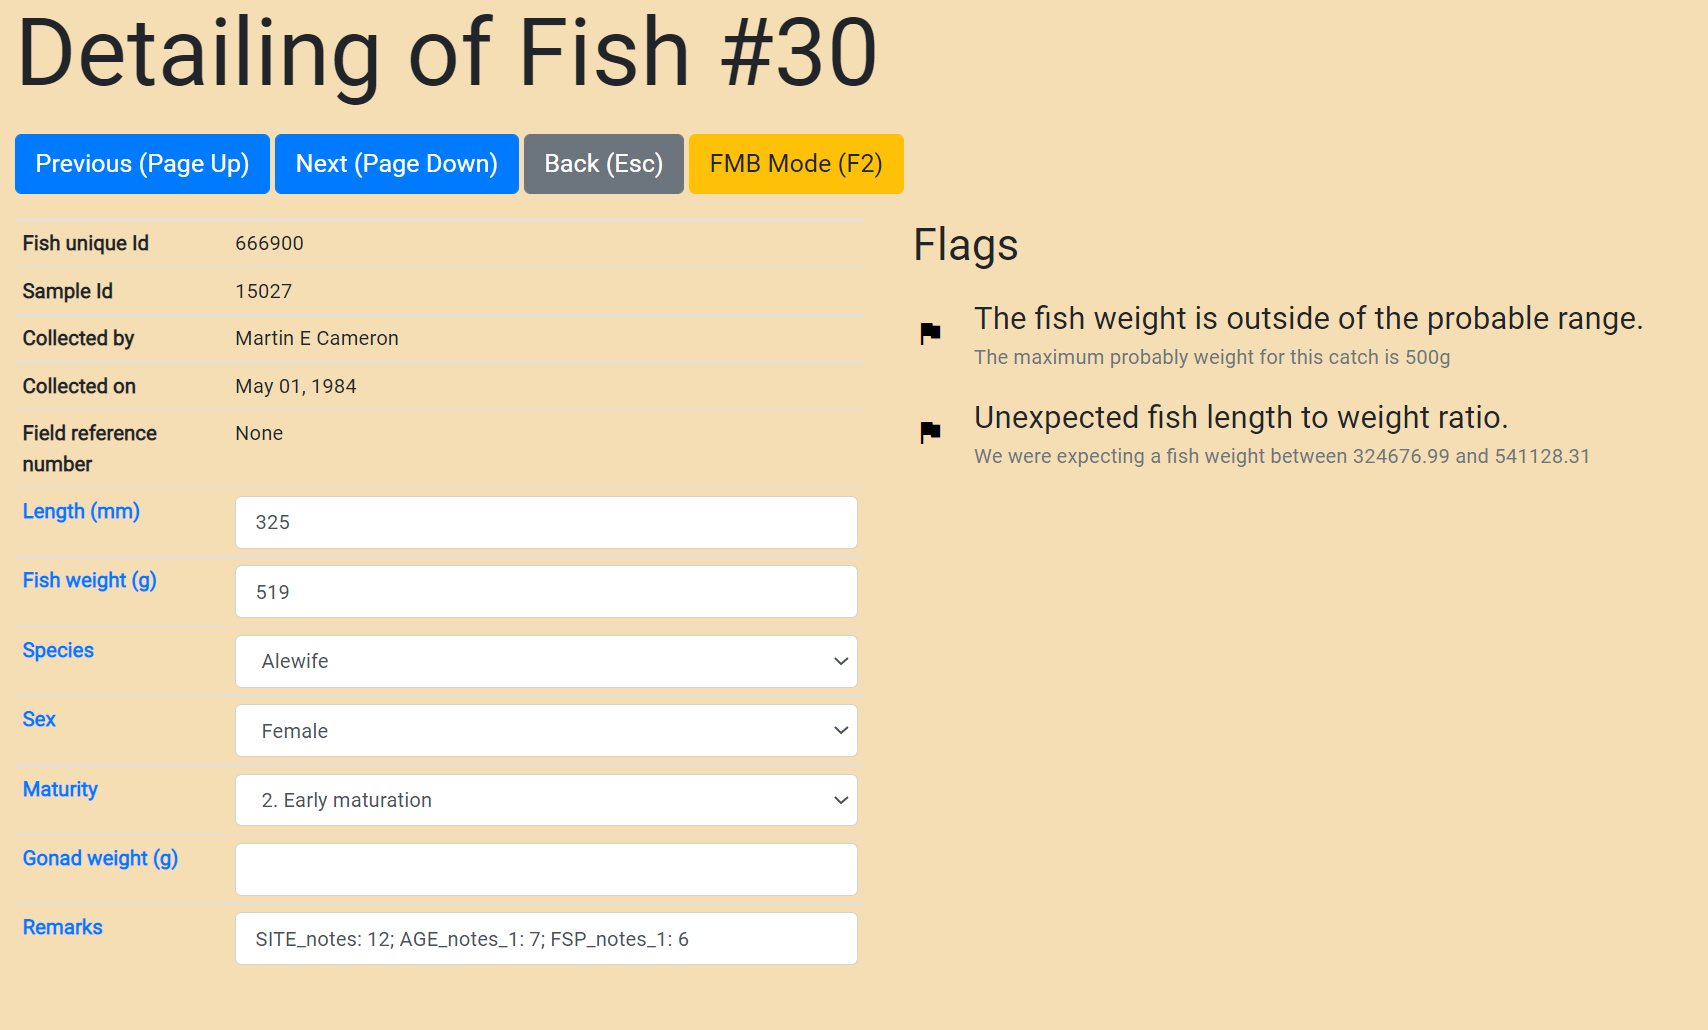

### GONAD_WEIGHT: Nullify outliers - CONFIRM

In [38]:
max_gonad_weight = 200

df_FD.loc[df_FD.GONAD_WEIGHT > max_gonad_weight]

,DATETIME,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,FLAG_SITE,SITE_notes,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,FLAG_SEX,FLAG_MATURITY,FLAG_FSP_1,FLAG_FL_STD,FLAG_FL_WET_FROZEN,FLAG_WEIGHT_OUTLIER
5590,1989-05-16,1989,5,16,<NA>,38,PM,Frozen,41,<NA>,270,278.000,283.000,A,F,4,417.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,38,38,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14050,1995-06-02,1995,6,2,5,41,AM,Frozen,7,<NA>,276,284.000,337.000,A,F,4,766.000,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"41,35",41,35,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23051,2008-05-20,2008,5,20,4,26,AM,Frozen,14,<NA>,260,268.000,277.300,A,F,4,414.800,NaN,5,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,5,4,NaN,NaN,NaN,NaN,NaN,26,26,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23498,2008-06-04,2008,6,4,6,5,AM,Fresh,24,240,<NA>,240.000,176.400,A,F,4,219.600,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,NaN,NaN,NaN,NaN,NaN,5,5,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25251,2010-05-05,2010,5,5,2,41,PM,Frozen,30,<NA>,262,270.000,233.700,A,F,4,335.500,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26652,2011-06-04,2011,6,4,5,41,AM,Fresh,32,255,<NA>,255.000,220.300,A,F,4,280.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32829,2017-06-14,2017,6,14,7,25,AM,Frozen,14,<NA>,246,254.000,183.400,B,F,4,256.000,JM,5,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,5,3,NaN,NaN,NaN,NaN,NaN,25,25,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# flag weight outliers
df_FD.loc[(df_FD.GONAD_WEIGHT > max_gonad_weight), 'FLAG_GONAD_OUTLIER'] = True

# how many flags?
df_FD[df_FD.FLAG_GONAD_OUTLIER == True].shape[0]

7

In [40]:
# # leave for now

# confirm_GONAD_null = True  # all of these have gonads that weight more than the total weight

# if confirm_GONAD_null:
#      df_FD.loc[df_FD.GONAD_WEIGHT > max_gonad_weight, 'GONAD_WEIGHT'] = np.nan

### Validate weight to length ratio - CONFIRM

##### need to flag these and manually deal with them individually 


[4:25 PM] Fishman, David
would be based on length in cm and weight in g

<img style="float: left;" src=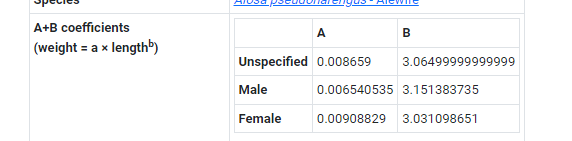>

In [41]:
# TODO: add a flag or boolean to identify outliers?


def lw_prediction_delta(sex, length_mm, weight_g):
    """
    returns actual weight / predicted weight, based on length and sex
    """
    
    sex, length_mm, weight_g = str(sex), float(length_mm), float(weight_g)
    
    if sex.lower()[0] == 'm':
        A, B = 0.00654, 3.15
    elif sex.lower()[0] == 'f':
        A, B = 0.00909, 3.03
    else:
        A, B = 0.00866, 3.06
        
    # in grams, length converted mm to cm
    predicted_weight_g = A * ((length_mm / 10) ** B)
    
    return weight_g / predicted_weight_g


In [42]:
try:
    print(sum(df_FD.drop('lw_ratio_check', axis=1).loc[:, 'FLAG_SITE':].any(axis=1)))
except KeyError:
    print(sum(df_FD.loc[:, 'FLAG_SITE':].any(axis=1)))

36912


In [43]:
# check the length width ratio outliers

# drop FLAG_LEN_WT_RATIO_OUTLIER before recalculating, ignore if doesn't exist
df_FD = df_FD.drop('FLAG_LEN_WT_RATIO_OUTLIER', axis=1, errors='ignore')

# initialise column to np.nan
df_FD['lw_ratio_check'] = np.nan  

for i, row in df_FD.iterrows():
    if row['FLAG_SITE':].any():  # don't include any flagged data in averages
        df_FD.loc[i, 'lw_ratio_check'] = np.nan
    else:
        try:
            df_FD.loc[i, 'lw_ratio_check'] = lw_prediction_delta(row['SEX'], row['FL_STD'], row['WEIGHT'])
        except TypeError:
            df_FD.loc[i, 'lw_ratio_check'] = np.nan
        
# number of samples with extraordinary dimensions
avg_ratio = df_FD['lw_ratio_check'].describe()['mean']
stdev = df_FD['lw_ratio_check'].describe()['std']

# how many standard deviations out should we examine?
n_stdev = 4
# with 3 stdev, there are 106 len wt ratio outliers excluding already flagged values

# min and max ratios
lw_ratio_min, lw_ratio_max = avg_ratio - n_stdev*stdev, avg_ratio + n_stdev*stdev

# flag lw ratio outliers
df_FD.loc[(df_FD['lw_ratio_check'] < lw_ratio_min) | (df_FD['lw_ratio_check'] > lw_ratio_max), 'FLAG_LEN_WT_RATIO_OUTLIER'] = True

# how many flags?
df_FD[df_FD.FLAG_LEN_WT_RATIO_OUTLIER == True].shape[0]

0

In [44]:
# here are our outliers
columns = ['CONDITION', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'WEIGHT', 'SPECIES', 'SEX', 'MATURITY', 'GONAD_WEIGHT', 'lw_ratio_check']
df_FD[df_FD.FLAG_LEN_WT_RATIO_OUTLIER == True][columns]

,CONDITION,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,lw_ratio_check


In [45]:
# drop the lw_ratio_check before continuing
df_FD = df_FD.drop('lw_ratio_check', axis=1)

### Create a combined 'remarks' column - CONFIRM

In [46]:
FD_comments = [
    'SITE_notes', 
    'Ager_1', 'Ager_2', 'Ager_3', 
    'Comments_1', 'Comments_2', 'Comments_3', 'Envelop.Comments', 
    'AGE_notes_1', 'FSP_notes_1', 'AGE_notes_2', 'FSP_notes_2', 'AGE_notes_3', 'FSP_notes_3'
]

# # this complicated double lambda is a combination of these 3 concepts
# # there is likely a cleaner way to do this, so I left my logic here for posterity
# df_FD[FD_comments].apply(lambda x: '; '.join(x.dropna().astype(str)), axis=1)
# df_FD[FD_comments].apply(lambda x: x.name, axis=0).astype(str)
# df_FD[FD_comments].apply(lambda x: (x.dropna().name + ': ' + x.dropna().astype(str)), axis=0)

df_FD['remarks'] = df_FD[FD_comments].apply(lambda x: (x.dropna().name + ': ' + x.dropna().astype(str)), axis=0).apply(lambda x: '; '.join(x.dropna().astype(str)), axis=1)

In [47]:
# check a sample of the remarks
df_FD.sample(10)[['DATETIME', 'remarks']]

,DATETIME,remarks
28128,2013-05-22,SITE_notes: 41; Ager_1: JM; AGE_notes_1: 3; FSP_notes_1: 3
1581,1984-06-19,SITE_notes: 12; AGE_notes_1: 1; FSP_notes_1: 1
24914,2010-05-25,SITE_notes: 26; AGE_notes_1: 3; FSP_notes_1: 3
12309,1994-05-26,SITE_notes: 52
21998,2005-06-02,SITE_notes: 5; AGE_notes_1: 3; FSP_notes_1: 3
18530,2001-05-16,SITE_notes: 5; AGE_notes_1: 3; FSP_notes_1: 3
33075,2017-06-21,SITE_notes: 62; Ager_1: JM; AGE_notes_1: 4
13276,1995-05-27,SITE_notes: 33
12015,1994-05-19,SITE_notes: 33; AGE_notes_1: 4; FSP_notes_1: 4
3299,1986-06-02,SITE_notes: 12; AGE_notes_1: 3; FSP_notes_1: 3


### why did maturity distributions change in the 90s? - CONFIRM
* should we do anything to clean this?

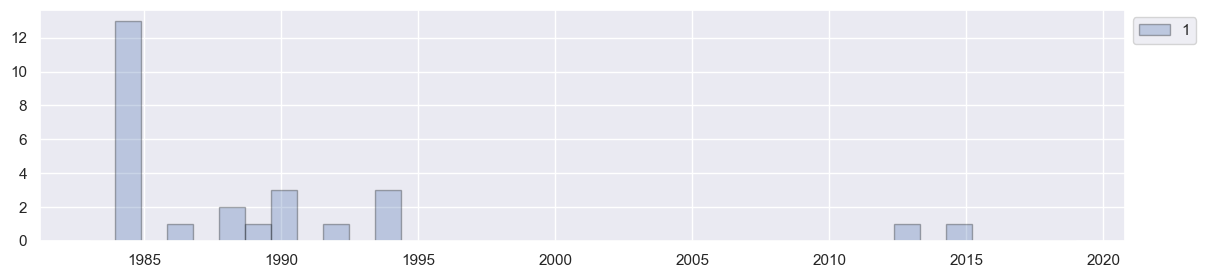

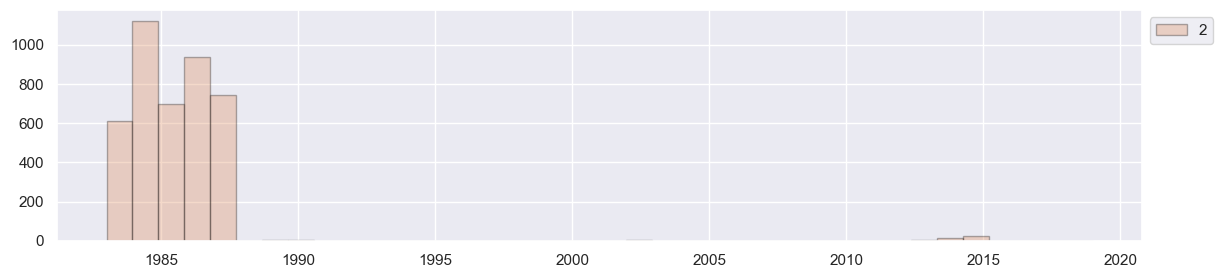

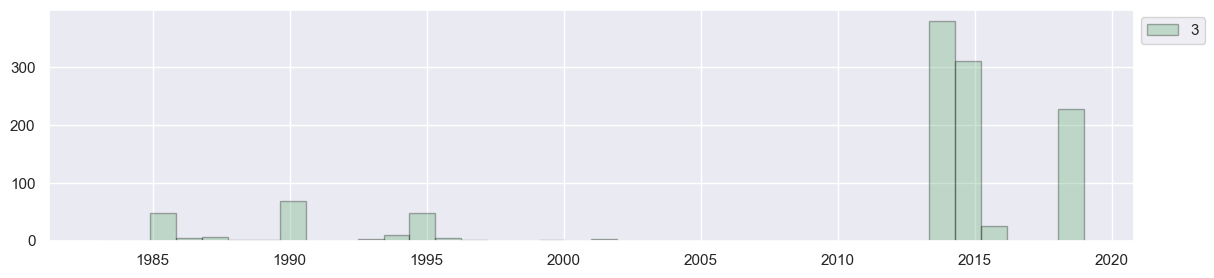

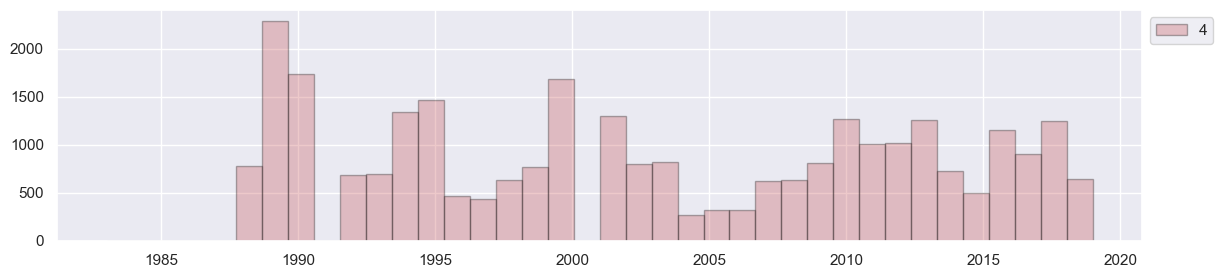

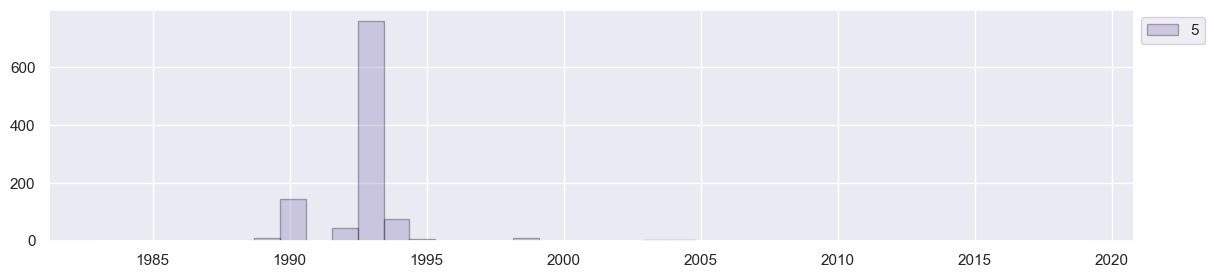

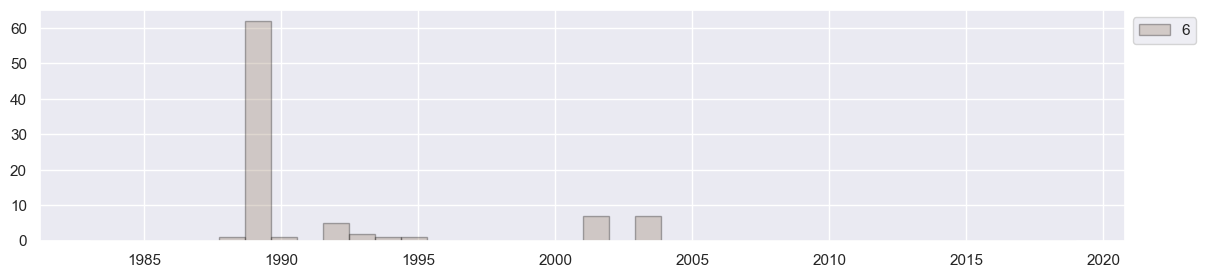

In [48]:
# share graphs
# look into, probably just import

possible_maturity = [1, 2, 3, 4, 5, 6]

for i, maturity in enumerate(possible_maturity):

    plt.figure(figsize=(14, 3))
    xmin, xmax = 1983, 2019
    bins = 2019 - 1983 + 1
    bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 

    df_FD.loc[df_FD.MATURITY == maturity, 'DATETIME'].dt.year.hist(alpha=0.3, bins=bins_plot, label=maturity, edgecolor='black', color=sns.color_palette()[i])
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

In [49]:
# CONFIRM
# clean this somehow?








# FISH DETAILS

In [50]:
df_FD['id'] = (
    df_FD.YEAR.astype(int)*1_000_000 
    + df_FD.MM.fillna(0).astype(int)*10_000
    + df_FD.DD.fillna(0).astype(int)*100
    + df_FD.SITE.fillna(0).astype(int)
).astype('Int64')

In [51]:
# ambiguous ids
ambiguous_id = df_FD[df_FD.duplicated(['id', 'FISH_NO'], keep=False)].groupby('id').count().index

# add 1B to duplicate ids (they will be invalidated at import)
df_FD.loc[df_FD.id.isin(ambiguous_id), 'id'] = df_FD.loc[df_FD.id.isin(ambiguous_id), 'id'] + 1_000_000_000

# LENGTH FREQUENCIES

In [52]:
df_LF = pd.read_csv(r'.\provided data\Margaree Gaspereau lgth-freq_Master.csv')

### Clean Date/Time and create DATETIME column

In [53]:
# convert all times to same format, set missing times to 0000 (date only), then to datetime format
df_LF['CleanTime'] = df_LF['Time']
df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] = df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] * 100
df_LF['CleanTime'] = pd.to_datetime(df_LF.CleanTime, format='%H%M')

# all null times should be 0000 (which pandas reads as no time data)
df_LF.loc[df_LF['CleanTime'].isnull(), 'CleanTime'] = pd.to_datetime(0)  

df_LF['DATETIME'] = pd.to_datetime(dict(
    year=df_LF['yy'], 
    month=df_LF['mm'], 
    day=df_LF['dd'], 
    hour=df_LF['CleanTime'].dt.hour, 
    minute=df_LF['CleanTime'].dt.minute
), errors='coerce')

df_LF = df_LF.drop('CleanTime', axis=1)

### Expand and Clean Site Column
* Later analysis shows matching with samples on the first noted site is more effective than combining multiple sites. 
* Consider adding extra sites to notes column or adding the ability to select multiple sites when inputting a sample.

In [54]:
df_LF[df_LF.site.isnull()].shape[0], df_LF[~(df_LF.site.str.isnumeric() | df_LF.site.isin(['1A', '1B']))].shape[0]
# null, total ambiguous

(69, 627)

In [55]:
df_LF.loc[(
    df_LF.site.isnull() | ~(df_LF.site.str.isnumeric() | df_LF.site.isin(['1A', '1B']))
)]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME
1205,1991,6,1,NaN,MARGAREE,5,"29,30",UPPER,AM,131.000,59.400,240,7,240,1991-06-01
1206,1991,6,1,NaN,MARGAREE,5,"29,30",UPPER,AM,131.000,59.400,245,8,245,1991-06-01
1207,1991,6,1,NaN,MARGAREE,5,"29,30",UPPER,AM,131.000,59.400,250,22,250,1991-06-01
1208,1991,6,1,NaN,MARGAREE,5,"29,30",UPPER,AM,131.000,59.400,255,38,255,1991-06-01
1209,1991,6,1,NaN,MARGAREE,5,"29,30",UPPER,AM,131.000,59.400,260,33,260,1991-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11384,2019,6,25,NaN,MARGAREE,9,John Albert Coady,NaN,AM,68.500,31.071,245,13,245,2019-06-25
11385,2019,6,25,NaN,MARGAREE,9,John Albert Coady,NaN,AM,68.500,31.071,250,5,250,2019-06-25
11386,2019,6,25,NaN,MARGAREE,9,John Albert Coady,NaN,AM,68.500,31.071,255,2,255,2019-06-25
11387,2019,6,25,NaN,MARGAREE,9,John Albert Coady,NaN,AM,68.500,31.071,260,1,260,2019-06-25


In [56]:
# flag ambiguous sites
df_LF.loc[(
    df_LF.site.isnull() | ~(df_LF.site.str.isnumeric() | df_LF.site.isin(['1A', '1B']))
), 'FLAG_SITE'] = True

# how many flags?
df_LF[df_LF.FLAG_SITE == True].shape[0]

627

In [57]:
df_LF[['SITE1', 'SITE2', 'SITE3']] = df_LF.site.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

### Clean River Column

In [58]:
df_LF.loc[df_LF.river == 'SW Margaree', 'river'] = 'SW MARGAREE'
df_LF.river.unique()

array([nan, 'MARGAREE', 'SW MARGAREE'], dtype=object)

### Clean Location

In [59]:
# clean the typos
df_LF.loc[df_LF['loc'] == 'LOWER ', 'loc'] = 'LOWER'
df_LF.loc[df_LF['loc'] == 'LOWE', 'loc'] = 'LOWER'
df_LF['loc'].unique()

array(['LOWER', 'UPPER', nan], dtype=object)

### 'river' and 'loc' should be included in Sites
* See Sites Section of this workbook below

### Period: AD

In [60]:
df_LF.period.unique()

array(['PM', 'AM', 'AD'], dtype=object)

In [61]:
# counts: AM, PM, and AD
sum(df_LF.period == 'AM'), sum(df_LF.period == 'PM'), sum(df_LF.period == 'AD')

(6143, 5250, 47)

In [62]:
# flag AD periods
df_LF.loc[df_LF.period == 'AD', 'FLAG_PERIOD'] = True

# how many flags?
df_LF[df_LF.FLAG_PERIOD == True].shape[0]

47

### Generate Unique IDs to Import / match with Samples

In [63]:
# replace non-numeric data with made up site numbers
# NOTE: These are converted back in import script
id_replacements = {
    '1A': 90,
    '1B': 91,
    'EricMcFarlane': 92,
    'JimmyMacFarlane': 93,
    'JohnAlbertCoady': 94
}
df_LF = df_LF.replace({'SITE1': id_replacements})

In [64]:
# 'unique' id column (note ambiguities, and solve later)
df_LF['id'] = (
    df_LF.DATETIME.dt.year*1_000_000 
    + df_LF.DATETIME.dt.month*10_000 
    + df_LF.DATETIME.dt.day*100 
    + df_LF.SITE1.fillna(0).astype(int)
).astype('Int64')

# new sample indicator
df_LF['new_sample'] = df_LF.lgth.diff() < 0

# new id indicator
df_LF['new_id'] = df_LF.id.diff() != 0

In [65]:
# update ids for ambiguous entries
duplicated_ids_LF = list(df_LF[~df_LF.new_id & df_LF.new_sample].id)

In [66]:
if df_LF.id.max() < 2_100_000_000: # only run this once

    # add 1B to duplicate ids
    df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] = df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] + 1_000_000_000

    # add an extra billion to every other id, so that all are now distinct
    previous_lgth = 0
    multiplier = False

    for i, row in df_LF[df_LF.id > 2_900_000_000].iterrows():

        current_lgth = row['lgth']
        if previous_lgth > current_lgth:
            multiplier = not multiplier

        df_LF.loc[i, 'id'] = row.id + 1_000_000_000*multiplier

        previous_lgth = current_lgth

In [67]:
df_LF = df_LF.drop(['new_id', 'new_sample'], axis=1)

### Length Bins

In [68]:
# use the same bins as used in the herring database (cm, grouped by 0.5s)
df_LF['length_bin_id'] = (df_LF.lgth - df_LF.lgth % 5) / 10

In [69]:
df_LF.head()

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,FLAG_SITE,SITE1,SITE2,SITE3,FLAG_PERIOD,id,length_bin_id
0,1990,5,7,NaN,NaN,2,12,LOWER,PM,NaN,NaN,250,1,250,1990-05-07,NaN,12,<NA>,<NA>,NaN,1990050712,25.000
1,1990,5,7,NaN,NaN,2,12,LOWER,PM,NaN,NaN,253,1,250,1990-05-07,NaN,12,<NA>,<NA>,NaN,1990050712,25.000
2,1990,5,7,NaN,NaN,2,12,LOWER,PM,NaN,NaN,255,2,255,1990-05-07,NaN,12,<NA>,<NA>,NaN,1990050712,25.500
3,1990,5,7,NaN,NaN,2,12,LOWER,PM,NaN,NaN,258,2,255,1990-05-07,NaN,12,<NA>,<NA>,NaN,1990050712,25.500
4,1990,5,7,NaN,NaN,2,12,LOWER,PM,NaN,NaN,260,7,260,1990-05-07,NaN,12,<NA>,<NA>,NaN,1990050712,26.000


# SAMPLES (logbook)

In [70]:
dtypes = {
    'code': 'object',
    'no_nets': 'object',
    'YEAR': 'Int32',
    'MM': 'Int32',
    'DD': 'Int32',
    'Week': 'Int32',
#     'hours_fished': 'Int32'  # some entries say 'maximum '
}
df_SD = pd.read_csv(r'.\provided data\Margaree Gaspereau logbooks_Master.csv', dtype=dtypes)

### replace hours_fished = 'maximum' with a number of hours - CONFIRM

In [71]:
df_SD.hours_fished.unique()

array(['14', '15', '10', '9', '12', '2', '0', '11', '8', '13', '7', '5',
       '4', '6', '3', '1', '16', '18', '17', nan, '7.5', '14.5', '15.5',
       '6.5', '5.5', '2.5', '9.5', '13.5', '0.5', '10.5', '11.5', '3.5',
       '12.5', '1.5', '4.5', '1.8', '16.5', 'maximum ', '8.5'],
      dtype=object)

In [72]:
sum(df_SD.hours_fished=='maximum ')

28

In [73]:
# flag 'maximum '
df_SD.loc[df_SD.hours_fished=='maximum ', 'FLAG_HOURS_FISHED'] = True

# how many flags?
df_SD[df_SD.FLAG_HOURS_FISHED == True].shape[0]

28

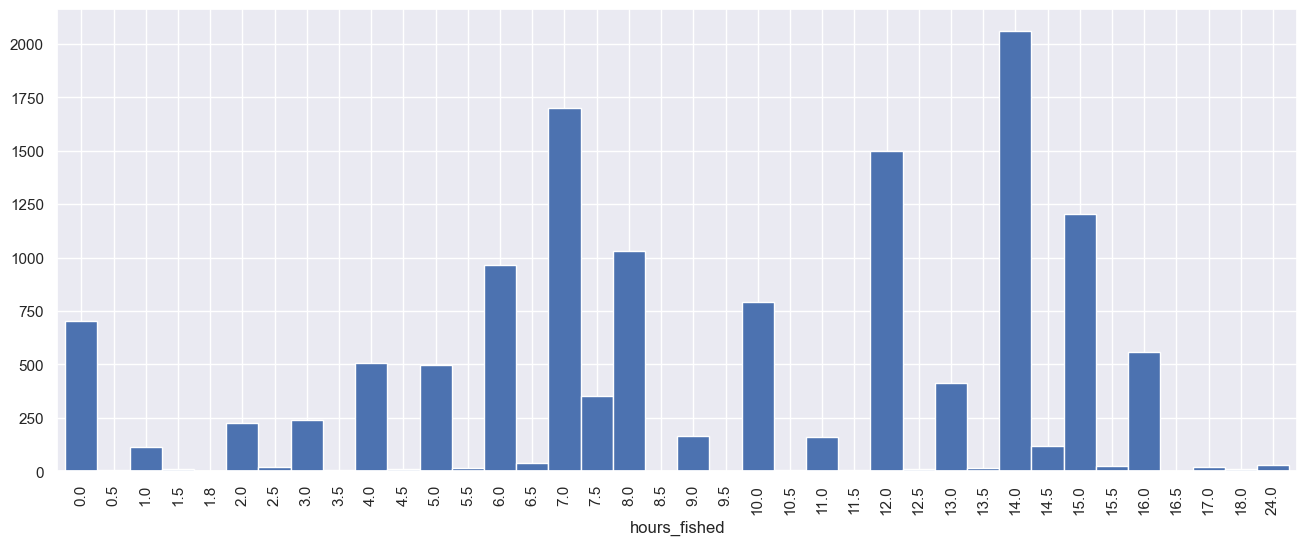

In [74]:
(
    df_SD.groupby('hours_fished')
    .count()
    .reset_index()
    .replace({'maximum ': 24})[['hours_fished', 'DIST']]
    .astype(float)
    .sort_values('hours_fished')
    .plot(kind='bar', x='hours_fished', y='DIST', width=1, figsize=(16, 6), legend=False)
);

In [75]:
# # leave for now

# # CONFIRM 24 is the correct time
# # will import better if it is numeric formatting
# numeric_hours_fished = True

# if numeric_hours_fished:
#     df_SD.loc[df_SD.hours_fished == 'maximum ', 'hours_fished'] = 24  # max could be 18
#     df_SD['hours_fished'] = pd.to_numeric(df_SD['hours_fished'], errors='coerce').astype(float)

### Samples.SITE_NO

In [76]:
sum(df_SD.SITE_NO=='1A,8'), sum(df_SD.SITE_NO=='1A'), sum(df_SD.SITE_NO=='1B'), sum(df_SD.SITE_NO=='1A,8') + sum(df_SD.SITE_NO=='1A') + sum(df_SD.SITE_NO=='1B')

(23, 62, 92, 177)

In [77]:
# add a flag for sites if there is ambiguous data (ie, names, multiple sites, alternate nomenclature)
df_SD.loc[(~df_SD.SITE_NO.str.isnumeric()) & (~df_SD.SITE_NO.isin(['1A', '1B'])), 'FLAG_SITE'] = True

# how many Site flags are there?
df_SD[df_SD.FLAG_SITE == True].shape[0]

23

In [78]:
# create columns for multiple sites
df_SD[['SITE1', 'SITE2']] = df_SD.SITE_NO.str.split(',', expand=True).fillna(pd.NA)

### DATETIME - leave incomplete dates null - CONFIRM
* confirm leave null when missing days/months

In [79]:
df_SD['DATETIME'] = pd.to_datetime(
    df_SD['YEAR'].astype(str) + '-' + df_SD['MM'].astype(str) + '-' + df_SD['DD'].astype(str), 
    errors='coerce'  # coerce missing days and months into errors
)

sum(df_SD.DATETIME.isnull())

31

In [80]:
# add a flag for sites if there is ambiguous data (ie, names, multiple sites, alternate nomenclature)
df_SD.loc[df_SD.DATETIME.isnull(), 'FLAG_DATETIME'] = True

# how many Site flags are there?
df_SD[df_SD.FLAG_DATETIME == True].shape[0]

31

### clean bycatch / pre-generate 'remarks' before import - CONFIRM

In [81]:
df_SD.bycatch_sbass.unique()

array([nan,  3.,  1.,  2.])

In [82]:
df_SD.bycatch_shad.unique()

array([nan,  1.])

In [83]:
df_SD.bycatch_other.unique()

array([nan, 'salmon', '1 perch, 1 speckled trou, 1 30 inch salmon',
       '1 lamprey eel (?)', '1', '2 trout', '1 trout', '5 lampreys',
       '1 baby lamprey', '4 trout, 3 "lamprey eels" (?)', '1 perch',
       '4 suckers', 'lamprey', '1 sucker'], dtype=object)

In [84]:
df_SD.comments.unique()

array([nan, 'striped bass were 23 inches',
       'river still high, fishing inside wing',
       'catch a salmon no marking 14 inch long', 'salted 4800 lbs',
       'salted 5000 lbs', 'outside wing in, river high',
       'salted 8000 lbs', '5 gaspereau', '26 gaspereau', 'did not fish',
       'Rainbow trout released', 'salmon', 'trout', 'salt', 'bait',
       'did not fish, returned logbook', 'wet snow', '6 fish',
       'heavy rain, flood', '3 fish', '10 fish', '1 fish', '8 fish',
       'heavy rain', 'did not fish on the 22nd. Water too high.'],
      dtype=object)

In [85]:
check_for_comments = ['comments', 'bycatch_sbass', 'bycatch_shad', 'bycatch_other']

# update bycatch fields to text fields
df_SD.loc[df_SD['bycatch_sbass'].notna(), 'comment_sbass'] = 'bycatch_sbass: ' + df_SD[df_SD['bycatch_sbass'].notna()]['bycatch_sbass'].astype(int).astype(str)
df_SD.loc[df_SD['bycatch_shad'].notna(), 'comment_shad'] = 'bycatch_shad: ' + df_SD[df_SD['bycatch_shad'].notna()]['bycatch_shad'].astype(int).astype(str)
df_SD.loc[df_SD['bycatch_other'].notna(), 'comment_other'] = 'bycatch_other: ' + df_SD[df_SD['bycatch_other'].notna()]['bycatch_other']

# combine with semicolon to make remarks field
df_SD['remarks'] = df_SD[['comments', 'comment_sbass', 'comment_shad', 'comment_other']].apply(lambda x: '; '.join(x.dropna()), axis=1)

# set empty strings to NaN
df_SD.loc[df_SD.remarks == '', 'remarks'] = np.nan  

# drop extra bycatch string columns
df_SD = df_SD.drop(['comment_sbass', 'comment_shad', 'comment_other'], axis=1)

In [86]:
# check results
df_SD[df_SD.remarks.notna()].sample(5)

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,FLAG_HOURS_FISHED,FLAG_SITE,SITE1,SITE2,DATETIME,FLAG_DATETIME,remarks
14431,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2017,6,8,6,7000.000,3175.100,7,lower,Chiasson,salted 5000 lbs,1.000,NaN,NaN,NaN,NaN,26,<NA>,2017-06-08,NaN,salted 5000 lbs; bycatch_sbass: 1
14411,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2017,6,6,6,8900.000,4037.000,7,lower,Chiasson,NaN,1.000,NaN,NaN,NaN,NaN,26,<NA>,2017-06-06,NaN,bycatch_sbass: 1
14978,2,SWMARG,Gerard MacFarlane,NaN,81,28,1,2019,6,8,6,1000.000,453.600,7.5,upper,MacFarlane,NaN,NaN,NaN,1 trout,NaN,NaN,28,<NA>,2019-06-08,NaN,bycatch_other: 1 trout
14937,2,SWMARG,Mary E Gillis,NaN,81,49,1,2019,5,14,3,250.000,113.400,13,upper,Gillis,wet snow,NaN,NaN,NaN,NaN,NaN,49,<NA>,2019-05-14,NaN,wet snow
14556,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2017,6,20,8,1450.000,657.700,7,lower,Chiasson,NaN,NaN,NaN,1 lamprey eel (?),NaN,NaN,26,<NA>,2017-06-20,NaN,bycatch_other: 1 lamprey eel (?)


### Sample unique ID

In [87]:
# same site replacements from LF
df_SD = df_SD.replace({'SITE1': id_replacements})
df_SD['SITE1'] = df_SD['SITE1'].astype(int)

# 'unique' id column
df_SD['id'] = (
    df_SD.YEAR.astype(int)*1_000_000 
    + df_SD.MM.fillna(0).astype(int)*10_000
    + df_SD.DD.fillna(0).astype(int)*100
    + df_SD.SITE1.fillna(0).astype(int)
).astype('Int64')

# duplicated ids
duplicated_ids_SD = set(df_SD[df_SD.duplicated('id', keep=False)].id)

In [88]:
# some of these ids end up with an extra digit
if df_SD.id.max() < 2_100_000_000:
    
    # initialise number of handled repeats as zero for each id
    n_repeats = dict(zip(duplicated_ids_SD, [0 for x in duplicated_ids_SD]))
    
    for i, row in df_SD[df_SD.id.isin(duplicated_ids_SD)].iterrows():
        df_SD.loc[i, 'id'] = row['id'] + 1_000_000_000 * int(n_repeats[row['id']] + 1)
        n_repeats[row['id']] += 1

### Add Ghost Sample Data for unmatched length frequencies and fish details - CONFIRM
### * (date, site, all else null)
* if these null data are added, all fish detail and length frequencies should get into dm_apps
* if null data are not added, unmatched fish detail and length frequencies will be added to rejected files (csv generated on import)

In [89]:
# how many length frequency measurements are matched with samples?
(
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique(), 
    df_LF.id.nunique(), 
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique() / df_LF.id.nunique()
)

(731, 917, 0.797164667393675)

In [90]:
# how many fish detail sample ids are matched with samples id column?
(
    df_FD[df_FD.id.isin(set(df_SD.id))].id.nunique(), 
    df_FD.id.nunique(), 
    df_FD[df_FD.id.isin(set(df_SD.id))].id.nunique() / df_FD.id.nunique()
)

(908, 1145, 0.7930131004366813)

In [91]:
# TODO: create ghost entries
# wait until revised data




add_null_data_where_unmatched = False  # CONFIRM

# IDEA: could add a check so that only non-ambiguous data is matched to be imported (ie, dummy_id < 2024000000)
#       dummy_id < 2024000000 are rejected at the import phase regardless

if add_null_data_where_unmatched:
    # add null samples where no match exists - Length Frequencies
    df_SD = pd.concat([
        df_SD, 
        df_LF[~df_LF.id.isin(set(df_SD.id))].drop_duplicates('id')[['id', 'DATETIME', 'SITE1']]
    ]).reset_index(drop=True)
    
    # add null samples where no match exists - Fish Details
    df_SD = pd.concat([
        df_SD, 
        df_FD[~df_FD.id.isin(set(df_SD.id))].rename({'id':'id'},axis=1).drop_duplicates('id')[['id', 'DATETIME', 'SITE1']]
    ]).reset_index(drop=True)

### Merge data into Sample table as required

In [92]:
df_SD.shape

(15213, 28)

In [93]:
# JOIN with Fish Details table to get total_fish_preserved
# NOTE: this is an estimate, assuming all fish details are accounted for. This is the best information available
df_SD = pd.merge(
    df_SD, 
    pd.merge(df_SD, df_FD, on='id').groupby('id').count()['FISH_NO'].reset_index(),
    on='id',
    how='left'
).rename({'FISH_NO':'total_fish_preserved'}, axis=1)

# JOIN with Length Frequencies table to get total_fish_measured
# NOTE: this is an estimate, assuming all length frequencies are accounted for. This is the best information available
df_SD = pd.merge(
    df_SD, 
    pd.merge(df_SD, df_LF, on='id').groupby('id').sum()['freq'].reset_index(),
    on='id',
    how='left'
).rename({'freq':'total_fish_measured'}, axis=1)

# JOIN with Length Frequency to get PERIOD
df_SD = pd.merge(
    df_SD, 
    pd.merge(df_SD, df_LF[['id', 'period']], on='id').groupby('id').first()['period'].reset_index(),
    on='id',
    how='left'
)

# JOIN with Length Frequency table to get sample weight
df_SD = pd.merge(
    df_SD, 
    df_LF[['id', 'wt_lbs']],
    on='id', 
    how='left'  # all samples 
).drop_duplicates().reset_index(drop=True)

# sort in numerical order - id (date), then fish_number
df_SD = df_SD.sort_values('id').reset_index(drop=True)

In [94]:
df_SD.shape

(15213, 32)

# Sample.NAME column -> TrapSupervisors
Create Samplers Table / Clean Sampler Names - CONFIRM

In [95]:
# Sampler -> TrapSupervisor text field
# linked to Site? like a notes field, concatenated list of all trapsupervisors
# filter in sites table 'icontains' 
# is it important? it's the site that matters

# SHOULD ANY OF THESE BE SUBSTITUTED / SPELLING CORRECTED?

sorted([str(x) for x in df_SD.NAME.unique()])

['Alexander Gillis',
 'Alexander MacDonald',
 'Allan B Gillis',
 'Anthony Cameron',
 'Brian Doyle',
 'Brian MacFarlane',
 'Bruce MacLellan',
 'Bruce McLellan',
 'Catherine MacFarlane',
 'Catherine MacLeod',
 'Charles McDaniel',
 'Chris MacLean',
 'Colin Gillis',
 'Daniel Stewart',
 'Darlene Cameron',
 'David MacKinnon',
 'Donald D Gillis',
 'Donald J Gillis',
 'Donald M Campbell',
 'Donald MacEachern',
 'Donald MacLeod',
 'Donald Macleod',
 'Donelda M Gillis',
 'Eleanor MacLellan',
 'Eleanor McDaniel',
 'Elizabeth MacKinnon',
 'Elizabeth/Vincent MacKinnon',
 'Finley MacDonald',
 'Finley Stewart',
 'Florence Gillis',
 'Fred Ingram',
 'Gerard MacFarlane',
 'Gerard V Chiasson',
 'Harold MacFarlane',
 'Hugh J Gillis',
 'Hughie MacDonnell',
 'Irene MacIsaac',
 'Jack MacLellan',
 'James A Hirtle',
 'James MacFarlane',
 'Jim Coady',
 'Jim MacFarlane',
 'Joan Ingram',
 'John A Chisholm',
 'John A Coady',
 'John Coady',
 'John H Gillis',
 'John MacLellan',
 'John Neil Gillis',
 'John R Gillis',

In [96]:
# Clean NAME column manually - CONFIRM
sampler_replacements = {
#     'Bruce MacLellan': 'Bruce McLellan',                     # CONFIRM
#     'Elizabeth/Vincent MacKinnon': 'Elizabeth MacKinnon',    # CONFIRM
    'Kevin MacKinnon ': 'Kevin MacKinnon',
    'Donald Macleod': 'Donald MacLeod'
}

# clean the name column
df_SD = df_SD.replace({'NAME': sampler_replacements})

In [97]:
# create TrapSupervisors table

gaspereau_TrapSupervisors = list()

for i in sorted(str(x) for x in df_SD.NAME.unique()):
    name = i.rsplit(maxsplit=1)  # put initials into first name
    gaspereau_TrapSupervisors.append(name)
    
gaspereau_TrapSupervisors = pd.DataFrame(gaspereau_TrapSupervisors, columns=['first_name', 'last_name'])
gaspereau_TrapSupervisors['notes'] = pd.NA  # all null comments

# SITES Table
### UPPER / LOWER cleaning and analysis

In [98]:
df_SD.loc[df_SD.zone == 'upper ', 'zone'] = 'upper'
df_SD.zone.unique()

array(['upper', 'lower', nan], dtype=object)

In [99]:
# how many zones per site?

df_SD.groupby(['SITE1', 'zone']).count().reset_index().groupby('SITE1').count()['zone'].sort_values(ascending=False).head()

SITE1
12    2
1     1
56    1
41    1
43    1
Name: zone, dtype: int64

In [100]:
df_SD.groupby(['SITE1', 'zone']).count().reset_index().query('SITE1 == "12"')[['SITE1', 'zone', 'NAME']].rename({'NAME':'count'}, axis=1)

,SITE1,zone,count


In [101]:
df_LF.groupby(['SITE1', 'loc']).count().reset_index().groupby('SITE1').count()['loc'].sort_values(ascending=False).head()

SITE1
12    2
62    2
90    1
52    1
41    1
Name: loc, dtype: int64

In [102]:
df_LF.groupby(['SITE1', 'loc']).count().reset_index().query('SITE1 == "12"')[['SITE1', 'loc', 'yy']].rename({'yy':'count'}, axis=1)

,SITE1,loc,count
5,12,LOWER,622
6,12,UPPER,12


In [103]:
df_LF.groupby(['SITE1', 'loc']).count().reset_index().query('SITE1 == "62"')[['SITE1', 'loc', 'yy']].rename({'yy':'count'}, axis=1)

,SITE1,loc,count
33,62,LOWER,12
34,62,UPPER,278


### count potential issues with ambiguous site data (all flagged above)

In [104]:
# how many issues are there?

# Sample Data

df_SD[df_SD.SITE_NO.str.isnumeric()].shape[0], df_SD[~df_SD.SITE_NO.str.isnumeric()].shape[0]
# numeric, non-numeric

(15036, 177)

In [105]:
# Fish Details

df_FD[df_FD.SITE_notes.str.isnumeric()].shape[0], df_FD[~df_FD.SITE_notes.str.isnumeric()].shape[0]
# numeric, non-numeric

(34954, 1958)

In [106]:
# Length Frequencies

temp = df_LF[df_LF.site.notna()]
temp[temp.site.str.isnumeric()].shape[0], temp[~temp.site.str.isnumeric()].shape[0]

# numeric, non-numeric

(10784, 587)

## Create Site table

In [107]:
# group, sort by most common, drop duplicates, create table
df_Site = (
    df_SD
        .groupby(['SITE1', 'zone'])
        .count()
        .reset_index()[['SITE1', 'zone', 'NAME']]
        .rename({'NAME':'count'}, axis=1)
        .sort_values('count', ascending=False)
        .sort_values('SITE1')
        .drop_duplicates('SITE1')
        .drop('count', axis=1)
        .rename({'SITE1': 'site'}, axis=1)
)

df_Site[['latitude_n', 'longitude_w', 'license_number', 'name']] = pd.NA

In [109]:
df_Site

,site,zone,latitude_n,longitude_w,license_number,name
0,1,lower,<NA>,<NA>,<NA>,<NA>
1,2,lower,<NA>,<NA>,<NA>,<NA>
2,4,lower,<NA>,<NA>,<NA>,<NA>
3,5,lower,<NA>,<NA>,<NA>,<NA>
4,6,lower,<NA>,<NA>,<NA>,<NA>
5,7,lower,<NA>,<NA>,<NA>,<NA>
6,8,lower,<NA>,<NA>,<NA>,<NA>
7,9,lower,<NA>,<NA>,<NA>,<NA>
8,11,lower,<NA>,<NA>,<NA>,<NA>
10,12,upper,<NA>,<NA>,<NA>,<NA>
